In [ ]:
import seaborn as sns
import matplotlib as plt

%matplotlib inline
plt.style.use('ggplot')

import numpy as np
import os
import re
import random
import numpy as np 
import pandas as pd 

import nltk
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# BERT y librerias Deep Learning 
import tensorflow_hub as hub
import tensorflow as tf
from keras import layers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#montamos drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_ini = pd.read_csv('/content/drive/MyDrive/TAC Notebooks/TA Final/archive/concat_dataset.csv')
df_ini.sample(3)

,ticker_symbol,current_monday,body,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,next_monday,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,abs_dif,rel_dif,type_dif
1312,TSLA,2015-01-12,$TSLA - TSLA May have more room to fall- - ht...,40.610001,41.521999,37.000000,38.613998,38.613998,153996000,2015-01-19,38.773998,40.700001,37.408001,40.257999,40.257999,81058500.0,-1.836003,-0.045211,-1
1110,MSFT,2016-03-07,Windows 10 updates for Windows 8.1 phones to b...,51.560001,53.070000,50.580002,53.070000,48.551579,171158000,2016-03-14,52.709999,55.000000,52.630001,53.490002,48.935818,172729500.0,1.149998,0.022304,1
1293,MSFT,2019-09-09,RT stock_family: https://investors.com/market-...,139.589996,139.750000,134.509995,137.320007,134.797302,129776500,2019-09-16,135.830002,142.369995,135.660004,139.440002,136.878342,133467100.0,-3.759994,-0.026936,-1


In [ ]:
df = df_ini[df_ini["ticker_symbol"]=="GOOG"]
df.head(3)

,ticker_symbol,current_monday,body,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,next_monday,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,abs_dif,rel_dif,type_dif
524,GOOG,2014-12-29,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,530.732849,534.013855,522.665039,523.373108,523.373108,5970647,2015-01-05,521.827332,522.894409,489.655640,494.811493,494.811493,12449787.0,-8.905517,-0.016780,-1
525,GOOG,2015-01-05,Free 5€ in account balance for first 100.000 m...,521.827332,522.894409,489.655640,494.811493,494.811493,12449787,2015-01-12,493.584869,506.798584,486.225067,506.688873,506.688873,11947111.0,-28.242463,-0.054122,-1
526,GOOG,2015-01-12,#TOPTICKERTWEETS $FB $GOOG $GOOGL $YHOO $SPY $...,493.584869,506.798584,486.225067,506.688873,506.688873,11947111,2015-01-19,509.600891,540.685547,504.630524,538.471619,538.471619,9459399.0,16.016022,0.032448,1


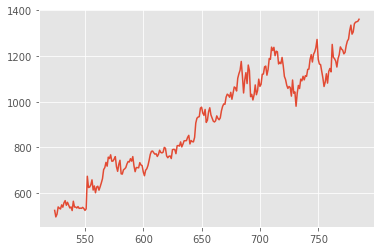

In [ ]:
#grafico de la evolucion de los precios de acciones en Google
import matplotlib.pyplot as plt
plt.plot(df["Close_x"])

In [ ]:
df1 = df.reset_index()["Close_x"]

In [ ]:
df1

0       523.373108
1       494.811493
2       506.688873
3       538.471619
4       533.056519
          ...     
257    1340.619995
258    1347.829956
259    1349.589966
260    1351.890015
261    1360.660034
Name: Close_x, Length: 262, dtype: float64

In [ ]:
#LSTM funciona mejor en datos con scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1

array([[0.03298685],
       [0.        ],
       [0.01371762],
       [0.05042467],
       [0.04417057],
       [0.04011631],
       [0.06085977],
       [0.0492729 ],
       [0.07167489],
       [0.08236912],
       [0.05891328],
       [0.07393239],
       [0.0600881 ],
       [0.04533383],
       [0.05049375],
       [0.03211148],
       [0.07934573],
       [0.04976451],
       [0.05013403],
       [0.04508697],
       [0.05231688],
       [0.04307739],
       [0.04448645],
       [0.04333151],
       [0.04836701],
       [0.04259233],
       [0.03301794],
       [0.04079064],
       [0.20571554],
       [0.14869634],
       [0.15106394],
       [0.16225528],
       [0.187456  ],
       [0.13589962],
       [0.15657301],
       [0.12229451],
       [0.15124877],
       [0.15526793],
       [0.13531059],
       [0.15256534],
       [0.1718528 ],
       [0.19332309],
       [0.23928955],
       [0.24946454],
       [0.27597034],
       [0.2566136 ],
       [0.30234905],
       [0.295

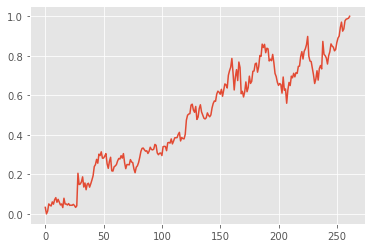

In [ ]:
#verificamos como la grafica se mantiene identica a la primera
plt.plot(df1)

In [ ]:
#separamos train y test
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(183, 79)

In [ ]:
train_data

array([[0.03298685],
       [0.        ],
       [0.01371762],
       [0.05042467],
       [0.04417057],
       [0.04011631],
       [0.06085977],
       [0.0492729 ],
       [0.07167489],
       [0.08236912],
       [0.05891328],
       [0.07393239],
       [0.0600881 ],
       [0.04533383],
       [0.05049375],
       [0.03211148],
       [0.07934573],
       [0.04976451],
       [0.05013403],
       [0.04508697],
       [0.05231688],
       [0.04307739],
       [0.04448645],
       [0.04333151],
       [0.04836701],
       [0.04259233],
       [0.03301794],
       [0.04079064],
       [0.20571554],
       [0.14869634],
       [0.15106394],
       [0.16225528],
       [0.187456  ],
       [0.13589962],
       [0.15657301],
       [0.12229451],
       [0.15124877],
       [0.15526793],
       [0.13531059],
       [0.15256534],
       [0.1718528 ],
       [0.19332309],
       [0.23928955],
       [0.24946454],
       [0.27597034],
       [0.2566136 ],
       [0.30234905],
       [0.295

In [ ]:
#funcion que convierte la data en una matriz donde cada registro es una sub serie temporal de 4 semanas, es decir 4 features por registro
#asi dejamos el que les sigue como target
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 4
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_test.shape), print(ytest.shape)

(74, 4)
(74,)


(None, None)

In [ ]:
#manejamos la dimensionalidad para que la red pueda trabajar con los datos propuestos
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
#la arquitectura de la red consta de 3 capas de LSTM y una capa densa al final
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(4,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 4, 50)             10400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 4, 50)             20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
3/3 [==============================] - 7s 566ms/step - loss: 0.1650 - val_loss: 0.5422
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 0.1360 - val_loss: 0.4591
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 0.1063 - val_loss: 0.3625
Epoch 4/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0733 - val_loss: 0.2494
Epoch 5/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0432 - val_loss: 0.1270
Epoch 6/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0208 - val_loss: 0.0319
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0245 - val_loss: 0.0059
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0311 - val_loss: 0.0103
Epoch 9/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0220 - val_loss: 0.0338
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0159 - val_loss: 0.0626
Epoch 11/50
3/3 [===========

In [ ]:
#Predecimos los valores sobre el test
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
#transformacion inversa del scaler para mostrar los datos originales que se predijeron
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
#error cuadrado medio del entrenamiento
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

828.4878630417826

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))

1201.551400133618

In [ ]:
tf.__version__

'2.5.0'

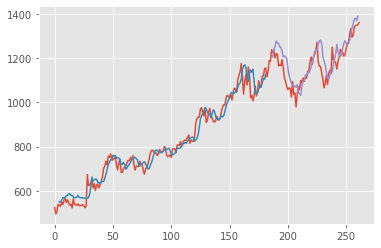

In [ ]:
#graficamos la data de entrenamiento junto a la data predecida y los datos originales en rojo
import matplotlib.pyplot as plt
look_back=4
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()